In [1]:
from tqdm import tqdm
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from skimage.io import imread, imshow, imsave
from enum import Enum
from keras.utils.all_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.layers import Rescaling
from keras.models import Model, load_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import datetime
import matplotlib.pyplot as plt
from keras.optimizers import adam_v2
from keras.losses import binary_crossentropy
from keras.applications.resnet import ResNet50
from keras.metrics import Precision, Recall

In [2]:
import os
import cv2
import glob
import json
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
from skimage.io import imread, imshow, imsave
from enum import Enum
from keras.utils.all_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, Rescaling
from keras.models import Model, load_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import datetime
import matplotlib.pyplot as plt
from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator
from itertools import count
import albumentations as A
from torch.utils.data import Dataset
from skimage.morphology import remove_small_objects

from torchvision.utils import draw_segmentation_masks
import torch
import torchvision.transforms as transforms

import cv2
import numpy as np
from PIL import Image, ImageEnhance
from skimage.filters import threshold_otsu
from scipy import ndimage
from skimage.morphology import convex_hull_image
from skimage.util import invert

In [3]:
def load_images_and_patchify(directory_path, patch_size, add_reflected = False, vertical_flip=False, rotate=None):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            filepath = os.path.join(root,file)
            extension = filepath.split(".")[-1]
            if extension == "jpg" or extension == "png" or extension == "bmp":
    
                # current image path
                img_path = filepath
    
                # Reads image as BGR
                image = imread(img_path)
    
                # convert image to RBG
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
                #size_x = (image.shape[1] // patch_size) * patch_size  # get width to nearest size divisible by patch size
                #size_y = (image.shape[0] // patch_size) * patch_size  # get height to nearest size divisible by patch size
    
                #image = Image.fromarray(image)
    
                # Crop original image to size divisible by patch size from top left corner
                #image = np.array(image.crop((0, 0, size_x, size_y)))
    
                # Extract patches from each image, step=patch_size means no overlap
                patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    
                # iterate over vertical patch axis
                for j in range(patch_img.shape[0]):
                    # iterate over horizontal patch axis
                    for k in range(patch_img.shape[1]):
                        # patches are located like a grid. use (j, k) indices to extract single patched image
                        single_patch_img = patch_img[j, k]
    
                        # Drop extra extra dimension from patchify
                        instances.append(np.squeeze(single_patch_img))
                        if add_reflected == True:
                            instances.append(cv2.flip(np.squeeze(single_patch_img), 1))
                        if vertical_flip == True:
                            instances.append(cv2.flip(np.squeeze(single_patch_img), 0))
                            
                if rotate != None:
                    img_for_rot = Image.fromarray(image)
                    
                    for i in range(len(rotate)):
                        im_rot = np.array(img_for_rot.rotate(rotate[i]))
                        instances.append(im_rot)
            
                        # Extract patches from each image, step=patch_size means no overlap
                        patch_img = patchify(im_rot, (patch_size, patch_size, 3), step=step)
            
                        # iterate over vertical patch axis
                        for j in range(patch_img.shape[0]):
                            # iterate over horizontal patch axis
                            for k in range(patch_img.shape[1]):
                                # patches are located like a grid. use (j, k) indices to extract single patched image
                                single_patch_img = patch_img[j, k]
            
                                # Drop extra extra dimension from patchify
                                instances.append(np.squeeze(single_patch_img))
                                if add_reflected == True:
                                    instances.append(cv2.flip(np.squeeze(single_patch_img), 1))
                                if vertical_flip == True:
                                    instances.append(cv2.flip(np.squeeze(single_patch_img), 0))
    
    return instances

In [4]:
def load_images(directory_path, size, add_reflected = False, vertical_flip=False, rotate=None):
    """
    :param size: 
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            filepath = os.path.join(root,file)
            extension = filepath.split(".")[-1]
            if extension == "jpg" or extension == "png" or extension == "bmp":
    
                # current image path
                img_path = filepath
    
                # Reads image as BGR
                image = imread(img_path)
    
                # convert image to RBG
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
                image = cv2.resize(image, dsize = [size, size], interpolation=cv2.INTER_NEAREST)
    
                instances.append(image)
        
                if add_reflected == True:
                    instances.append(cv2.flip(image, 1))
                if vertical_flip == True:
                    instances.append(cv2.flip(image, 0))
                    
                if rotate != None:
                    img_for_rot = Image.fromarray(image)
                    for i in range(len(rotate)):
                        im_rot = np.array(img_for_rot.rotate(rotate[i]))
                        
                        instances.append(im_rot)
                
                        if add_reflected == True:
                            instances.append(cv2.flip(im_rot, 1))
                        if vertical_flip == True:
                            instances.append(cv2.flip(image, 0))
                        
    
    return instances

In [5]:
def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset 
    :param num_classes: number of classes
    :return: 
    """
    # initialise list for integer encoded masks
    integer_encoded_labels = []

    # iterate over each mask
    for mask in masks:

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)

In [6]:
def dice_index(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2. * intersection + smooth)/(union + smooth)
    return dice

In [7]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_index(y_true, y_pred)
    return loss

In [8]:
def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [9]:
def tversky_index(y_true, y_pred, smooth=1):
    y_true_pos = K.flatten(y_true[:,:,:,1])
    y_pred_pos = K.flatten(y_pred[:,:,:,1])
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    tversky = (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
    return tversky

In [10]:
def tversky_loss(y_true, y_pred):
    loss = 1 - tversky_index(y_true,y_pred)
    return loss

In [11]:
def bce_tversky_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + tversky_loss(y_true, y_pred)
    return loss

In [12]:
def jaccard_index(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    jaccard = (intersection + smooth) / (union - intersection + smooth)
    return jaccard

In [13]:
def jaccard_loss(y_true, y_pred):
    loss = 1 - jaccard_index(y_true, y_pred)
    return loss

In [14]:
def bce_jaccard_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + jaccard_loss(y_true, y_pred)
    return loss

In [15]:
def get_training_data(root_directory, size, patching = False, add_reflected = False, vertical_flip=False, rotate=None):
    # initialise lists
    image_dataset, mask_dataset = [], []

    # define image patch size
    #patch_size = 160
    # walk through root directory
    for path, directories, files in os.walk(root_directory):
        for subdirectory in directories:

            # extract training input images and patchify
            if subdirectory == "images":
                if patching == True:
                    image_dataset.extend(
                        load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size, add_reflected = add_reflected, vertical_flip=vertical_flip, rotate=rotate))
                else:
                    image_dataset.extend(
                        load_images(os.path.join(path, subdirectory), size=size, add_reflected = add_reflected, vertical_flip=vertical_flip, rotate=rotate))

            # extract training label masks and patchify
            elif subdirectory == "masks":
                if patching == True:
                    mask_dataset.extend(
                        load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size, add_reflected = add_reflected, vertical_flip=vertical_flip, rotate=rotate))
                else:
                    mask_dataset.extend(
                        load_images(os.path.join(path, subdirectory), size=patch_size, add_reflected = add_reflected, vertical_flip=vertical_flip, rotate=rotate))
                    
    
    # return input images and masks
    return np.array(image_dataset), np.array(mask_dataset)

In [16]:
def display_images(instances, rows=2, titles=None):
    """
    :param instances:  list of images
    :param rows: number of rows in subplot
    :param titles: subplot titles
    :return:
    """
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    # iterate through images and display subplots
    for j, image in enumerate(instances):
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image)

    # show the figure
    plt.show()

In [17]:
def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))

    # iterate over MaskColorMap
    for j, cls in enumerate(MaskColorMap):
        # convert single integer channel to RGB channels
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image

In [18]:
def img_pre_proc(im):
    # подсвечиваем все копилляры
    # converting to LAB color space
#    lab= cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
#    l_channel, a, b = cv2.split(lab)
    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
#    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(10,10))
#    cl = clahe.apply(l_channel)
    # merge the CLAHE enhanced L-channel with the a and b channel
#    limg = cv2.merge((cl,a,b))
    # Converting image from LAB Color model to BGR color spcae
#    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    enhanced_img = im
    #####################################################
    # увеличиваем контрастность исходного изображения
    img = Image.fromarray(im)
    enhancer = ImageEnhance.Contrast(img)
    factor = 10
    im_output = enhancer.enhance(factor)
    im_output = np.array(im_output)
    #####################################################
    # получаем маску по засвеченной области
    im_gray = cv2.cvtColor(im_output, cv2.COLOR_BGR2GRAY)
    thresh = threshold_otsu(im_gray)
    binary = im_output > thresh
    binary = binary.astype('uint8')
    binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
    #####################################################
    # удаляем отдельно расположенные маленькие объекты и скругляем границы маски
    img_fill_holes = ndimage.binary_fill_holes(binary).astype(int)
    img_fill_holes = ((255 - img_fill_holes*255)/255).astype('uint8')
    img_fill_holes = ((255 - img_fill_holes*255)/255).astype('uint8')
    img_fill_holes = cv2.morphologyEx(img_fill_holes, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50)))
    ######################################################
    # оставляем только самый большой по площади объект маски и обворачиваем его
    cnts, _ = cv2.findContours(img_fill_holes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv2.contourArea)
    # Output
    out = np.zeros(img_fill_holes.shape, np.uint8)
    cv2.drawContours(out, [cnt], -1, 255, cv2.FILLED)
    img_fill_holes = cv2.bitwise_and(img_fill_holes, out)
    img_fill_holes = convex_hull_image(img_fill_holes).astype('uint8')
    
    
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! блок увеличения размера выделенной маски (улучшения не дал)
    #kernel = np.ones((3, 3), np.uint8)
    #img_fill_holes = cv2.dilate(img_fill_holes, kernel, iterations=40)
    
    
    ######################################################
    # применяем маску на изображение с подсвеченными копиллярами
    rows, cols, channels = im.shape
    colored_portion = cv2.bitwise_or(enhanced_img, enhanced_img, mask = img_fill_holes)
    colored_portion = colored_portion[0:rows, 0:cols]
    ######################################################
    # определяем параметры обрезки маски
    rows = np.any(img_fill_holes, axis=1)
    cols = np.any(img_fill_holes, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    ######################################################
    # обрезаем изображение с подсвеченными копиллярами и примененной маской
    cropped_im = Image.fromarray(colored_portion)
    cropped_im = cropped_im.crop((cmin, rmin, cmax, rmax))
    cropped_im = np.array(cropped_im)
    ######################################################
    # обрезаем маску
    cropped_mask = Image.fromarray(img_fill_holes)
    cropped_mask = cropped_mask.crop((cmin, rmin, cmax, rmax))
    cropped_mask = np.array(cropped_mask)
    
    return cropped_im, cropped_mask, [cmin, rmin, cmax, rmax]

In [19]:
def msk_pre_proc(msk, cropped_mask, crop_params):
    
    crp_mask = Image.fromarray(msk)
    crp_mask = crp_mask.crop(crop_params)
    crp_mask = np.array(crp_mask)
    
    rows, cols, channels = crp_mask.shape
    colored_portion = cv2.bitwise_or(crp_mask, crp_mask, mask = cropped_mask)
    colored_portion = colored_portion[0:rows, 0:cols]
    
    return colored_portion

In [20]:
def restore_shape(image, seg_result, crop_params):
    h, w, _ = image.shape
    restored = np.zeros((h, w))
    restored[crop_params[1]:crop_params[3], crop_params[0]:crop_params[2]] = seg_result
    
    return restored

In [21]:
# для удаления мелких объектов с изображения (меньше чем заданное количество пикселей)
def remove_small_blobs(binary_mask, min_size):
    """
    Removes from the input mask all the blobs having less than N adjacent pixels.
    We set the small objects to the background label 0.
    """
    if min_size > 0:
        dtype = binary_mask.dtype
        binary_mask = remove_small_objects(binary_mask.astype(bool), min_size=min_size)
        binary_mask = binary_mask.astype(dtype)
    return binary_mask

In [22]:
def median_frequency_balancing(masks, num_classes):
    '''
    Perform median frequency balancing on the image files, given by the formula:
    f = Median_freq_c / total_freq_c
    where median_freq_c is the median frequency of the class for all pixels of C that appeared in images
    and total_freq_c is the total number of pixels of c in the total pixels of the images where c appeared.
    INPUTS:
    - image_dir(string): the directory with training annotations
    - num_classes(int): the number of classes of pixels in all images
    OUTPUTS:
    - class_weights(list): a list of class weights where each index represents each class label and the element is the class weight for that label.
    '''
    #Initialize all the labels key with a list value
    label_to_frequency_dict = {}
    for i in range(num_classes):
        label_to_frequency_dict[i] = []

    for mask in masks:
        # get image shape
        _img_height, _img_width, _img_channels = mask.shape
        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)
        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j
        
        #For each image sum up the frequency of each label in that image and append to the dictionary if frequency is positive.
        for i in range(num_classes):
            class_mask = np.equal(encoded_image, i)
            class_mask = class_mask.astype(np.float32)
            class_frequency = np.sum(class_mask)

            if class_frequency != 0.0:
                label_to_frequency_dict[i].append(class_frequency)

    class_weights = []

    #Get the total pixels to calculate total_frequency later
    total_pixels = 0
    for frequencies in label_to_frequency_dict.values():
        total_pixels += sum(frequencies)

    for i, j in label_to_frequency_dict.items():
        j = sorted(j) #To obtain the median, we got to sort the frequencies

        median_frequency = np.median(j) / sum(j)
        total_frequency = sum(j) / total_pixels
        median_frequency_balanced = median_frequency / total_frequency
        class_weights.append(median_frequency_balanced)

    #Set the background class_weight to 0.0
    #class_weights[-1] = 0.0
    #class_weights[2] = 0.0

    return class_weights

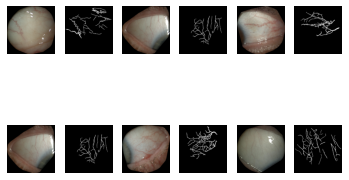

In [23]:
n_classes = 2
patch_size = 512
#overlap = 0.5
#rotate = [10, 20, 30, -30, -20, -10]
#model_save_path = "C:/Users/Aleksandr/Desktop/ML/Machine_Learning/My_Examples/Semantic_Segmentation/Face/FASSEG"

class MaskColorMap(Enum):
    background = (0, 0, 0)
    vessels = (255, 255, 255)
    
    
data_dir_best = r"C:/ML/MC/data_V11"
#data_dir_worst = r"C:/ML/MC/data_V8/Worst_data"

X, Y = get_training_data(data_dir_best, patch_size, patching=False)
#X_train, Y_train = get_training_data(data_dir_worst, patch_size, patching=False, add_reflected = True)
#X_test, Y_test = get_training_data(data_dir_best, patch_size, patching=False)

m, img_height, img_width, img_channels = X.shape

# display images from both training and test sets
display_count = 6
random_index = [np.random.randint(0, m) for _ in range(display_count)]
sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]
display_images(sample_images, rows=2)

In [24]:
X.shape

(643, 512, 512, 3)

In [25]:
Y = one_hot_encode_masks(Y, num_classes=n_classes)
#Y_train = one_hot_encode_masks(Y_train, num_classes=n_classes)
#Y_test = one_hot_encode_masks(Y_test, num_classes=n_classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [26]:
X_train.shape

(482, 512, 512, 3)

In [27]:
base_model = ResNet50(weights='imagenet', input_shape=(512,512,3), include_top=False)
base_out = base_model.output

In [28]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
conv1 = base_model.get_layer('conv1_relu').output
conv2 = base_model.get_layer('conv2_block1_out').output
conv3 = base_model.get_layer('conv3_block2_1_relu').output
conv4 = base_model.get_layer('conv4_block2_2_relu').output
conv5 = base_model.get_layer('conv5_block2_2_relu').output

In [30]:
x = base_out
    
# 1024    
x = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(x)
x = concatenate([x, conv4])
x = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

# 512
x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
x = concatenate([x, conv3])
x = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

# 256
x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
x = concatenate([x, conv2])
x = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

# 128
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
x = concatenate([x, conv1])
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

# 64
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
#x = concatenate([x, conv1])
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(x)

In [31]:
model_4 = Model(inputs=base_model.inputs, outputs=outputs)
model_4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [32]:
model_4.compile(optimizer=adam_v2.Adam(learning_rate=1e-4), loss=dice_loss, metrics=dice_index)

# train and save model
model_4.fit(X_train, Y_train, epochs=10, batch_size=4, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/10
121/121 [==============================] - 2452s 20s/step - loss: 0.4627 - dice_index: 0.5377 - val_loss: 0.4427 - val_dice_index: 0.5590
Epoch 2/10
121/121 [==============================] - 2415s 20s/step - loss: 0.2789 - dice_index: 0.7213 - val_loss: 0.2995 - val_dice_index: 0.7015
Epoch 3/10
121/121 [==============================] - 2394s 20s/step - loss: 0.2448 - dice_index: 0.7548 - val_loss: 0.2436 - val_dice_index: 0.7569
Epoch 4/10
121/121 [==============================] - 2410s 20s/step - loss: 0.2253 - dice_index: 0.7748 - val_loss: 0.2504 - val_dice_index: 0.7507
Epoch 5/10
121/121 [==============================] - 2519s 21s/step - loss: 0.2111 - dice_index: 0.7890 - val_loss: 0.2449 - val_dice_index: 0.7557
Epoch 6/10
121/121 [==============================] - 2472s 20s/step - loss: 0.1925 - dice_index: 0.8072 - val_loss: 0.2282 - val_dice_index: 0.7723
Epoch 7/10
121/121 [==============================] - 2458s 20s/step - loss: 0.1819 - dice_index: 0.8182 -

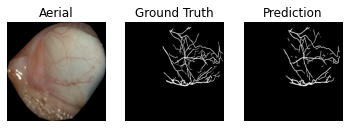

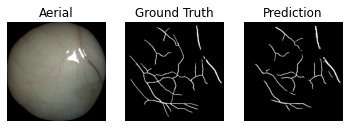

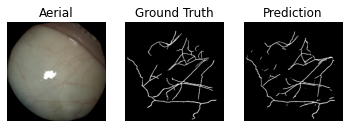

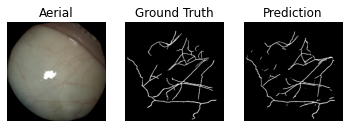

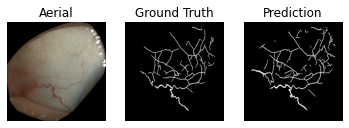

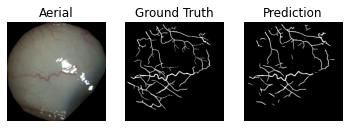

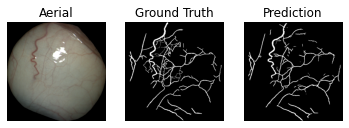

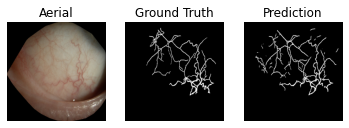

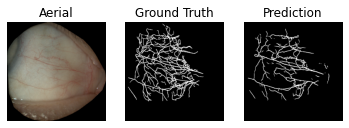

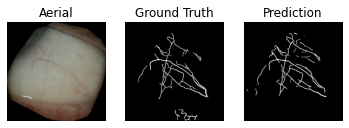

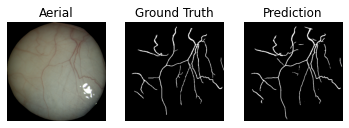

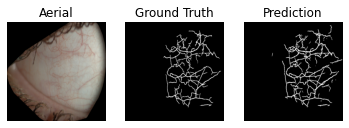

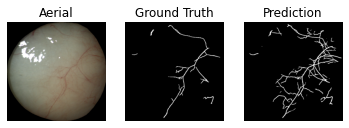

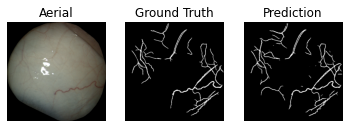

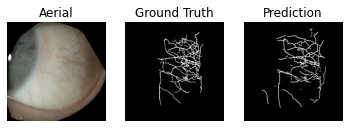

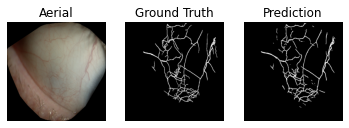

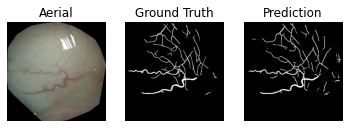

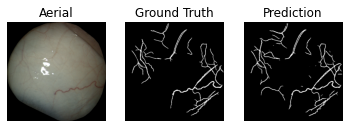

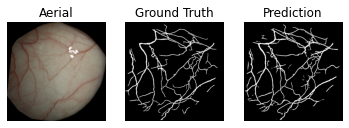

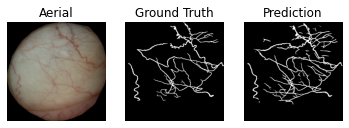

In [33]:
for _ in range(20):
    # choose random number from 0 to test set size
    test_img_number = np.random.randint(0, len(X_test))

    # extract test input image
    test_img = X_test[test_img_number]

    # ground truth test label converted from one-hot to integer encoding
    ground_truth = np.argmax(Y_test[test_img_number], axis=-1)

    # expand first dimension as U-Net requires (m, h, w, nc) input shape
    test_img_input = np.expand_dims(test_img, 0)

    # make prediction with model and remove extra dimension
    prediction = np.squeeze(model_4.predict(test_img_input))

    # convert softmax probabilities to integer values
    predicted_img = np.argmax(prediction, axis=-1)

    # convert integer encoding to rgb values
    rgb_image = rgb_encode_mask(predicted_img)
    rgb_ground_truth = rgb_encode_mask(ground_truth)

    # visualize model predictions
    display_images(
        [test_img, rgb_ground_truth, rgb_image],
        rows=1, titles=['Aerial', 'Ground Truth', 'Prediction']
    )

In [43]:
# предсказания модели, и сохранение в формате, необходимом для соревнования
for sample_path, sample_directories, sample_files in os.walk('C:/ML/MC/test_dataset_mc'):
    for sample_file in sample_files:
        sample_filename = sample_file.split(".")[0]
        filepath = sample_path + '/' + sample_file
        image = imread(filepath)
        
        cropped_img, cropped_mask, crop_params = img_pre_proc(image)
        cropped_img = msk_pre_proc(image, cropped_mask, crop_params)
        
        im = cv2.resize(cropped_img, dsize = [patch_size, patch_size])
        test_img_input = np.expand_dims(im, 0)
        prediction = np.squeeze(model_4.predict(test_img_input))
        predicted_img = np.argmax(prediction, axis=-1)
        rgb_image = rgb_encode_mask(predicted_img)
        rgb_image = cv2.resize(rgb_image, dsize = [cropped_img.shape[1], cropped_img.shape[0]], interpolation=cv2.INTER_NEAREST)   #, interpolation=cv2.INTER_LINEAR)
        rgb_image[rgb_image >= 0.5] = 1
        rgb_image[rgb_image < 0.5] = 0
        rgb_image = (rgb_image*255).astype('uint8')
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
        
        restored = restore_shape(image, rgb_image, crop_params)
        restored = remove_small_blobs(restored.astype('uint8'), 1000)
        kernel = np.ones((3, 3), np.uint8)
        restored = cv2.erode(restored, kernel, iterations=1)
        restored = restored * 255
        
        imsave('C:/ML/MC/Results/43_attempt_29_09_2022/43_10_test_7/images/' +  sample_filename + '.png', restored.astype('uint8'))

C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_28516/3986571000.py:28: UserWarning: C:/ML/MC/Results/43_attempt_29_09_2022/43_10_test_7/images/1004.png is a low contrast image
  imsave('C:/ML/MC/Results/43_attempt_29_09_2022/43_10_test_7/images/' +  sample_filename + '.png', restored.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_28516/3986571000.py:28: UserWarning: C:/ML/MC/Results/43_attempt_29_09_2022/43_10_test_7/images/1009.png is a low contrast image
  imsave('C:/ML/MC/Results/43_attempt_29_09_2022/43_10_test_7/images/' +  sample_filename + '.png', restored.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_28516/3986571000.py:28: UserWarning: C:/ML/MC/Results/43_attempt_29_09_2022/43_10_test_7/images/1011.png is a low contrast image
  imsave('C:/ML/MC/Results/43_attempt_29_09_2022/43_10_test_7/images/' +  sample_filename + '.png', restored.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_28516/3986571000.py:28: UserWarning: C:/ML/MC/R

In [58]:
# предсказания модели, и сохранение в формате, необходимом для соревнования
for sample_path, sample_directories, sample_files in os.walk('C:/ML/MC/data_V9/images'):
    for sample_file in sample_files:
        sample_filename = sample_file.split(".")[0]
        filepath = sample_path + '/' + sample_file
        image = imread(filepath)
        
        cropped_img, cropped_mask, crop_params = img_pre_proc(image)
        cropped_img = msk_pre_proc(image, cropped_mask, crop_params)
        
        im = cv2.resize(cropped_img, dsize = [patch_size, patch_size])
        test_img_input = np.expand_dims(im, 0)
        prediction = np.squeeze(model_4.predict(test_img_input))
        predicted_img = np.argmax(prediction, axis=-1)
        rgb_image = rgb_encode_mask(predicted_img)
        rgb_image = cv2.resize(rgb_image, dsize = [cropped_img.shape[1], cropped_img.shape[0]], interpolation=cv2.INTER_NEAREST)   #, interpolation=cv2.INTER_LINEAR)
        rgb_image[rgb_image >= 0.5] = 1
        rgb_image[rgb_image < 0.5] = 0
        rgb_image = (rgb_image*255).astype('uint8')
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
        
        restored = restore_shape(image, rgb_image, crop_params)
        restored = remove_small_blobs(restored.astype('uint8'), 400)
        restored = restored * 255
        
        imsave('C:/ML/MC/data_V9/masks/' +  sample_filename + '.png', restored.astype('uint8'))

C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/3731125552.py:26: UserWarning: C:/ML/MC/data_V9/masks/11.png is a low contrast image
  imsave('C:/ML/MC/data_V9/masks/' +  sample_filename + '.png', restored.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/3731125552.py:26: UserWarning: C:/ML/MC/data_V9/masks/118.png is a low contrast image
  imsave('C:/ML/MC/data_V9/masks/' +  sample_filename + '.png', restored.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/3731125552.py:26: UserWarning: C:/ML/MC/data_V9/masks/121.png is a low contrast image
  imsave('C:/ML/MC/data_V9/masks/' +  sample_filename + '.png', restored.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/3731125552.py:26: UserWarning: C:/ML/MC/data_V9/masks/122.png is a low contrast image
  imsave('C:/ML/MC/data_V9/masks/' +  sample_filename + '.png', restored.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/3731125552.py:26: UserWarning: C:/ML/

In [87]:
for old_path, old_directories, old_files in os.walk('C:/ML/MC/data_V2/masks'):
    break

for new_path, new_directories, new_files in os.walk('C:/ML/MC/data_V9/masks'):
    for file in new_files:
        filename = file.split(".")[0]
        
        new_filepath = new_path + '/' + file
        new_image = imread(new_filepath)
        
        old_filepath = old_path + '/' + file
        old_image = imread(old_filepath)
        old_image = cv2.cvtColor(old_image, cv2.COLOR_BGR2GRAY)
        
        new_image[old_image==255] = 255
        imsave('C:/ML/MC/data_V10/masks/' +  filename + '.png', new_image.astype('uint8'))

C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/657720033.py:16: UserWarning: C:/ML/MC/data_V10/masks/11.png is a low contrast image
  imsave('C:/ML/MC/data_V10/masks/' +  filename + '.png', new_image.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/657720033.py:16: UserWarning: C:/ML/MC/data_V10/masks/121.png is a low contrast image
  imsave('C:/ML/MC/data_V10/masks/' +  filename + '.png', new_image.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/657720033.py:16: UserWarning: C:/ML/MC/data_V10/masks/122.png is a low contrast image
  imsave('C:/ML/MC/data_V10/masks/' +  filename + '.png', new_image.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/657720033.py:16: UserWarning: C:/ML/MC/data_V10/masks/126.png is a low contrast image
  imsave('C:/ML/MC/data_V10/masks/' +  filename + '.png', new_image.astype('uint8'))
C:\Users\ALEKSA~1\AppData\Local\Temp/ipykernel_9636/657720033.py:16: UserWarning: C:/ML/MC/data_V10/masks/140

In [ ]:
# генерируем кропнутые изображения и маски для трейна
for mask_path, mask_directories, mask_files in os.walk('C:/ML/MC/data_V10/masks'):
    break

for sample_path, sample_directories, sample_files in os.walk('C:/ML/MC/data_V10/images'):
    for sample_file in sample_files:
        sample_filename = sample_file.split(".")[0]
        img_filepath = sample_path + '/' + sample_file
        msk_filepath = mask_path + '/' + sample_file
        image = imread(img_filepath)
        mask = imread(msk_filepath)
        if len(mask.shape) == 2:
            mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        
        cropped_img, cropped_mask, crop_params = img_pre_proc(image)
        cropped_img = msk_pre_proc(image, cropped_mask, crop_params)
        cropped_mask = msk_pre_proc(mask, cropped_mask, crop_params)
        
        imsave('C:/ML/MC/data_V11/images/' + sample_filename + '.png', cropped_img.astype('uint8'))
        imsave('C:/ML/MC/data_V11/masks/' + sample_filename + '.png', cropped_mask.astype('uint8'))

In [ ]:
# выявляем дубликаты в трейне
train = []
names = []
for sample_path, sample_directories, sample_files in os.walk('C:/ML/MC/train_dataset_mc'):
    for sample_file in sample_files:
        sample_filename = sample_file.split(".")[0]
        extantion = sample_file.split(".")[1]
        filepath = sample_path + '/' + sample_file
        if extantion == "png":
            image = (imread(filepath)).astype('uint8')
            train.append(image)
            names.append(int(sample_filename))

not_equal_shape = []
equal_images = []
for i in range(len(train)):
    for j in range(len(train)):
        if i != j:
            first = train[i]
            second = train[j]
            if first.shape == second.shape:
                difference = cv2.subtract(first, second)
                b, g, r = cv2.split(difference)
                if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
                    equal_images.append([names[i], names[j]])
                    print("The images are completely Equal: " + str(names[i]) + ' and ' + str(names[j]))
            else:
                if names[j] not in not_equal_shape and names[i] not in not_equal_shape:
                    not_equal_shape.append(names[j])
                    print("Shapes are not Equal: " + str(names[i]) + ' and ' + str(names[j]))

In [ ]:
# Сохраняем в отдельные директории изображения и их маски
for i, sample in enumerate(dataset):
#    image = sample['image']
    mask = sample['mask']
    mask = mask[:,:,1].astype('uint')
    mask[mask > 0] = 1
    mask = (mask*255).astype('uint8')
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
#    imsave('C:/ML/MC/data_V1/images/' + str(i) + '.png', (image*255).astype('uint8'))
    imsave('C:/ML/MC/data_V2/masks/' + str(i) + '.png', mask)